In [5]:
file = open("Tinystories.txt", "r")
full_data = file.read()
full_data = full_data[:500000]

In [6]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import time
import random
import math



torch.manual_seed(1)

inf = torch.inf
context_length = 256 # No of tokens in a batch
model_dim = 128 # dimension of the model -> residual stream
n_layers = 2 # no of layers
n_heads = 1 # No of attention heads for layer # TODO
head_dim = 128

learning_rate = 3e-4
max_iters = 5000
eval_iters = 100
batch_size = 16 

def tokenise(str):
    return torch.tensor([char_map[i] for i in str])

def decode(tokens):
    return ''.join([reverse_char_map[i] for i in tokens])


def sample_data(split: str = "train"):
    # Takes a random sample of context_length tokens from the training data
    data = training_data if split == 'train' else validation_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    return x, y # shape (batch_size, context_length)

vocab = list(sorted((set(full_data))))
vocab_size = len(vocab)
char_map = {vocab[i]: i for i in range(len(vocab))}
reverse_char_map = {char_map[i] : i for i in char_map}
full_data = tokenise(full_data)

total_datapoints  = full_data.shape[0]

training_data = full_data[:int(total_datapoints*0.8)]
validation_data = full_data[int(total_datapoints*0.8):total_datapoints]


print(len(full_data), len(training_data), len(validation_data))



500000 400000 100000


Model has 447k params
Initial training loss: 4.695395469665527, val loss: 4.692761421203613
iter:0 training loss: 4.695676326751709, val loss: 4.694064140319824
iter:250 training loss: 2.359830856323242, val loss: 2.342085361480713
iter:500 training loss: 2.273902177810669, val loss: 2.262828826904297
iter:750 training loss: 2.126649856567383, val loss: 2.113527536392212
iter:1000 training loss: 1.9007660150527954, val loss: 1.8879107236862183
iter:1250 training loss: 1.7421090602874756, val loss: 1.7182762622833252
iter:1500 training loss: 1.6334736347198486, val loss: 1.6116142272949219
iter:1750 training loss: 1.5604242086410522, val loss: 1.5505099296569824
iter:2000 training loss: 1.5041111707687378, val loss: 1.480196237564087
iter:2250 training loss: 1.4524229764938354, val loss: 1.4353121519088745
iter:2500 training loss: 1.4115402698516846, val loss: 1.403883695602417
iter:2750 training loss: 1.3830229043960571, val loss: 1.371964693069458
iter:3000 training loss: 1.3592127561

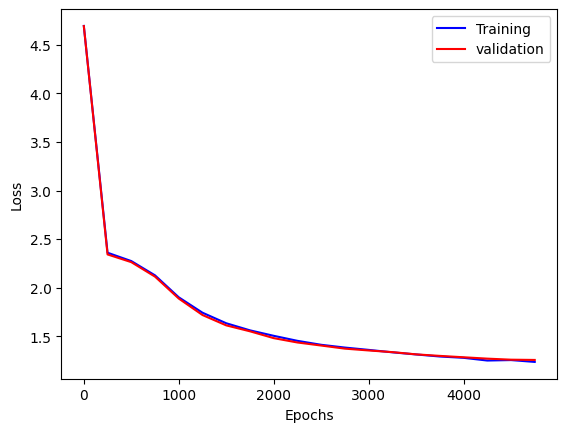

In [7]:


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = sample_data(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    
    return out["train"], out['val']


class AttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.key = nn.Linear(model_dim, head_dim)
        self.query = nn.Linear(model_dim, head_dim)
        self.value = nn.Linear(model_dim, head_dim)
        self.proj = nn.Linear(head_dim, model_dim)
    
    def forward(self, idx):
        key = self.key(idx) # (batch, context_length, head_dim)
        query = self.query(idx)
        value = self.value(idx) # (batch, context_length, head_dim)

        attention = (query@torch.transpose(key,1,2))/(math.sqrt(head_dim)) # (batch, context_length, context_length)

        attention = torch.tril(attention)

        attention = attention.masked_fill(attention == 0, -inf)

        attention = F.softmax(attention,-1) # probs along context_length sum to 1

        attention_value = attention@value  # (batch, context_length, head_dim)

        attention_value = self.proj(attention_value)  # (batch, context_length, model_dim)
        return attention_value
    

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(model_dim, 4*model_dim), nn.ReLU(), nn.Linear(4*model_dim, model_dim))
    
    def forward(self, idx):
        logits = self.layers(idx)
        return logits

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, model_dim)
        self.pos_embedding = nn.Embedding(context_length, model_dim)
        self.attention_layers = nn.ModuleList([AttentionHead() for i in range(n_layers)])
        self.mlp_layers = nn.ModuleList([MLP() for i in range(n_layers)])
        self.unembed_layer = nn.Linear(model_dim,vocab_size)

        self.total_parameters = sum([p.numel() for p in self.parameters()])
        print(f"Model has {self.total_parameters//1000}k params")


    def forward(self, idx, targets = None):

        input_sequence_length = idx.shape[-1]

        residual_stream = self.token_embedding(idx)  # (batch, context_length, model_dim)
        residual_stream = residual_stream + self.pos_embedding(torch.tensor([i for i in range(input_sequence_length)])) # (context_length, model_dim)
        
        for i in range(n_layers):
            residual_stream = residual_stream + self.attention_layers[i](residual_stream) # Exchange information from res strem of other tokens
            residual_stream = residual_stream + self.mlp_layers[i](residual_stream) # Computation block on the same token

        residual_stream = self.unembed_layer(residual_stream) # (batch, context_length, vocab_size)
        if targets is None:
            return residual_stream
        (x,y,z) = residual_stream.shape
        loss = F.cross_entropy(residual_stream.view(x*y,z), targets.view(x*y))
        return residual_stream, loss
    

model = Transformer()


train_loss,val_loss = estimate_loss()
print(f"Initial training loss: {train_loss}, val loss: {val_loss}")

loss_value = []
val_loss_value = []
iters = []
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
step_value = max_iters/20
start_time = time.time()
for iter in range(max_iters):
    X,Y= sample_data() # (B, context_length)
    logits, loss = model(X, Y)  # (B, context_length, vocab_size)
    if iter%step_value ==0:
        train_loss,val_loss = estimate_loss()
        iters.append(iter)
        loss_value.append(train_loss)
        val_loss_value.append(val_loss)
        print(f"iter:{iter} training loss: {train_loss}, val loss: {val_loss}")

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()

In [14]:
def generate_text(input: str, temperature = 0.7):
    max_tokens = 1000
    input_tokens = tokenise(input)
    print(input, end='')
    
    for i in range(max_tokens):
        now = model(input_tokens.unsqueeze(0))[0][-1]
        now = now/temperature # P(Xi) = exp(Xi/temperature)/Parition function
        now = F.softmax(now, dim= 0)
        token = torch.multinomial(now,1).item()
        input_tokens = torch.tensor(input_tokens.tolist() + [token])
        text = decode([token])
        print(text, end='')
        input_tokens = input_tokens[-context_length:]
                

generate_text("John and mary")  

John and mary friends, and he were with the balways little bird and play and her right, and head a nevery hugged to see and monked the bug boing the bird. The remembered to his mant to dreame. They show turnought be tring to his friend.
<|endoftext|>
Once upon a time, there a like the on the like to see to his man to played together. They and her mom and guinally. The trees and happy and play on the hungrass sorry thing strous on a big tree who bee the friend.
One day, the special like in the ground. She said, "Don't liff a was a big and new the boy gum saw a big make the special everyone.
The wanted to sear to the play and happer a proud of him the the sun with him. The bird not find it was sad a rock. Tim and the girl and saw a near and sail. They small looked at at a hought hat and the the end of his owl.
<|endoftext|>
Once upon a time, there in his fally find the sked happy to gething unick and his mom and the park.
One day, a looked to Tim like a loved how bird from in the said, "